# Setup

In [18]:
from pyspark.sql import SparkSession
from pyspark import SparkContext, SparkConf
from pyspark.sql import functions as F


spark = SparkSession.builder.master('local[*]').getOrCreate()
#spark.conf.set('spark.cores.max', '1')
#spark.conf.set('spark.driver.memory','1000M')

sc = spark.sparkContext

spark

## Lectura datos

In [19]:
df_orig = spark.read.format("parquet").option("inferSchema", "true").option("timestampFormat", "yyyy-MM-dd HH:mm:ss").option("header", "true").option("mode", "DROPMALFORMED").load("yellow_tripdata_2024-01.parquet")

In [20]:
df_orig.count()

2964624

In [21]:
df_orig = df_orig.select(["tpep_pickup_datetime", "tpep_dropoff_datetime", "trip_distance"])

### Velocidad media por hora (DataFrames)

Cálculo de datos a usar:
- Conversión de la distancia del viaje de millas a kilómetros
- Cálculo de la duración del viaje en horas
- Cálculo de la hora de inicio del viaje (parámetro por el que se agrupará)

In [22]:
df = (
    df_orig
        # Distancia en millas a kilómetros
        .withColumn("distance", df_orig["trip_distance"] * 1.60934)
        # Duración en horas. `timestamp_diff` trunca la parte decimal, por lo que calculamos la duración en segundos
        # y la convertimos a horas manualmente
        .withColumn("duration", F.timestamp_diff("second", "tpep_pickup_datetime", "tpep_dropoff_datetime") / 3600)
        # Hora de inicio del viaje
        .withColumn("hour", F.hour("tpep_pickup_datetime"))
)

Limpieza de datos:

In [23]:
total = df.count()
invalid = df.filter(df.duration == 0).count()
print(f"Total: {total}, invalid: {invalid} ({invalid / total * 100:.4f}%)")

Total: 2964624, invalid: 814 (0.0275%)


Hay pocos viajes inválidos (duración 0), por lo que podemos eliminarlos:

In [24]:
df_clean = df.filter(df.duration != 0)

Cálculo de la velocidad media por hora:

In [25]:
df_result = df_clean.withColumn("speed", df["distance"] / df["duration"]).groupBy("hour").avg("speed")

Resultados obtenidos:

In [26]:
df_result.sort(df_result.hour.asc()).toPandas()

,hour,avg(speed)
0,0,24.549710
1,1,24.112866
2,2,22.158310
3,3,23.352761
4,4,29.637736
5,5,57.650991
6,6,89.448763
7,7,50.871505
8,8,26.505114
9,9,18.092813


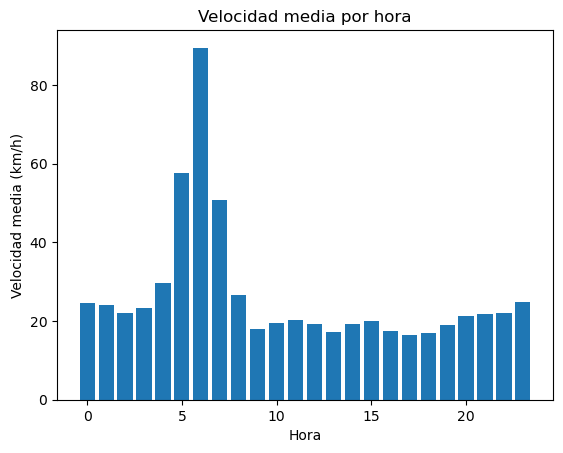

In [28]:
import matplotlib as mpl
import matplotlib.pyplot as plt
data = df_result.collect()

x1 = [x.hour for x in data]
y1 = [x["avg(speed)"] for x in data]

plt.bar(x1, y1)
plt.plot()

plt.xlabel("Hora")
plt.ylabel("Velocidad media (km/h)")
plt.title("Velocidad media por hora")
plt.show()

### Velocidad media por hora (SQL)

Obtenemos los datos y convertimos los datos en una vista de sql

In [29]:
df_orig = spark.read.format("parquet").option("inferSchema", "true").option("timestampFormat", "yyyy-MM-dd HH:mm:ss").option("header", "true").option("mode", "DROPMALFORMED").load("yellow_tripdata_2024-01.parquet")
df_orig.createOrReplaceTempView("yellow_trip_orig")

Ahora procedemos a convertir la distancia de millas a km y de nuevo creamos una nueva vista

In [30]:
df_sql = spark.sql("SELECT tpep_pickup_datetime, tpep_dropoff_datetime, trip_distance * 1.60934 AS trip_distance_km FROM yellow_trip_orig").createOrReplaceTempView("yellow_trip_dist_km")

A continuación calculamos la duración del viaje y obtenemos de la fecha de recogida la hora

In [31]:
df = spark.sql("SELECT trip_distance_km, (unix_timestamp(tpep_dropoff_datetime) - unix_timestamp(tpep_pickup_datetime)) / 3600 AS duration_hours, hour(tpep_pickup_datetime) AS hour FROM yellow_trip_dist_km")
df.createOrReplaceTempView("yellow_trip")

Realizamos un limpieza de datos

In [32]:
total = df.count()
invalid = df.filter("duration_hours = 0").count()
print(f"Total: {total}, invalid: {invalid} ({invalid / total * 100:.4f}%)")

Total: 2964624, invalid: 814 (0.0275%)


In [33]:
df = spark.sql("Select trip_distance_km, duration_hours, hour from yellow_trip Where duration_hours != 0")
df.show(10)
df.createOrReplaceTempView("yellow_trip_clean")

+------------------+-------------------+----+
|  trip_distance_km|     duration_hours|hour|
+------------------+-------------------+----+
|         2.7680648|               0.33|   0|
|          2.896812|               0.11|   0|
|          7.563898| 0.2986111111111111|   0|
|2.2530759999999996|0.13833333333333334|   0|
|1.2874720000000002|0.10166666666666667|   0|
|          7.563898| 0.5397222222222222|   0|
|        17.4130588|0.43416666666666665|   0|
|           4.82802| 0.4666666666666667|   0|
|         8.7548096| 0.4697222222222222|   0|
|         0.0643736|0.01888888888888889|   0|
+------------------+-------------------+----+
only showing top 10 rows


Obtenemos la velocidad media por hora

In [34]:
df = spark.sql("Select hour, AVG(trip_distance_km / duration_hours) AS avg_speed FROM yellow_trip_clean GROUP BY hour Order By (hour)")

Obtenemos los resultados

In [35]:
df.toPandas()

,hour,avg_speed
0,0,24.549710
1,1,24.112866
2,2,22.158310
3,3,23.352761
4,4,29.637736
5,5,57.650991
6,6,89.448763
7,7,50.871505
8,8,26.505114
9,9,18.092813
